# IMPORTS

In [1]:
import numpy as np
import copy

import matplotlib.pyplot as plt
%matplotlib inline

# FRAMEWORK

In [2]:
class Tic:  
    WINNING_CONDITIONS = np.array([[1, 2, 3],
                                    [4, 5, 6],
                                    [7, 8, 9],
                                        
                                    [1, 4, 7],
                                    [2, 5, 8],
                                    [3, 6, 9],

                                    [1, 5, 9],
                                    [7, 5, 3]])
    
    def __init__(self, state=np.array([])):
        self.state = state
        self.options = np.setdiff1d(np.arange(1,10), self.state)
        self.player = 'circles' if len(self.state) % 2 == 0 else 'crosses'
        self.winner = self.check_winner()
        
        
    def __str__(self):
        return str(self.state)
    
    
    def check_winner(self):        
        for condition in self.WINNING_CONDITIONS:
            if sum([1 for j in condition if j in self.state[::2]]) == 3:
                return 'crosses'
            elif sum([1 for j in condition if j in self.state[1::2]]) == 3:
                return 'circles'
    
    
    def choose(self, choice, show=False):
        self.state = np.append(self.state, choice)
        self.options = np.setdiff1d(np.arange(1,10), self.state)
        self.winner = self.check_winner()
        
        if show:
            self.show()

    
    def show(self):
        crosses = self.state[::2]
        circles = self.state[1::2]
        
        board = np.chararray(9)
        for cross in crosses:
            board[int(cross)-1] = 'X'
        for circle in circles:
            board[int(circle)-1] = 'O'
        for option in self.options:
            board[int(option)-1] = '_'
        
        print(board.reshape((3,3)))
        if self.winner is not None:
            print(f'{self.winner} wins')
        print()
         

class Node:
    def __init__(self, action=None, parent=None, player='crosses'):
        self.action = action
        self.player = player
        self.parent = parent
        self.children ={}
        self.rewards = []
        self.ucb_hist = []
        self.mean_rewards = [0]
    
    
    def ucb(self, i, c=1):
        if len(self.rewards) > 0:
            self.ucb_hist.append(self.mean_rewards[-1] + c*np.sqrt(np.log(i)/(2*len(self.rewards))))
            return self.ucb_hist[-1]
        else:
            self.ucb_hist.append(1.5)
            return self.ucb_hist[-1]

            
class MCTS:   
    def __init__(self, state=Tic()):
        self.root_state = copy.deepcopy(state)
        self.root = Node(player=state.player)
        self.i = 1

        
    def search(self, n=10, valuefunction='ucb', e=0.05):
        for i in range(n):
            node, state = self.select_node(valuefunction, e)
            outcome = self.roll_out(state)
            self.backup(node, outcome)
            
            if i == n-1:
                node, state = self.select_node(valuefunction, e, show=True)
                outcome = self.roll_out(state, show=True)
                self.backup(node, outcome)
            
            self.i += 1
        
        
    def select_node(self, valuefunction, e, show=False):
        node = self.root
        state = copy.deepcopy(self.root_state)

        while len(node.children) != 0:
            
            node = self.get_next_node(node, valuefunction, e)
            state.choose(node.action)
            
            if show:
                state.show()
            
            if len(node.rewards) == 0:
                return node, state
        
        if self.expand(node, state):
            node = np.random.choice(list(node.children.values()))
            state.choose(node.action)
            
        return node, state
    
    
    def get_next_node(self, node, valuefunction, e):
        children = list(node.children.values())
        
        if valuefunction == 'ucb':
            values = [n.ucb(self.i, e) for n in children]
            next_node = children[np.argmax(values)]
        elif valuefunction == 'greedy':
            if np.random.uniform() > e:
                values = [n.mean_rewards[-1] for n in children]
                next_node = children[np.argmax(values)]
            else:
                next_node = np.random.choice(children)
        else:  # valuefunction == 'random':
            next_node = np.random.choice(children)
        
        return next_node            
    
    def expand(self, parent, state):
        if (state.winner is not None) or (len(state.options) == 0):
            return False
        
        else:
            player = 'crosses' if parent.player == 'circles' else 'circles'
            
            for action in state.options:
                parent.children[action] = Node(action, parent, player)
                
            return True

    
    def roll_out(self, state, show=False):
        actions = state.options

        while (state.winner is None) and (len(state.options) > 0):
            action = np.random.choice(actions)
            state.choose(action)
            actions = np.delete(actions, np.where(actions==action))
            
            if show:
                state.show()
        
        return state.winner


    def backup(self, node, outcome):

        if outcome == 'crosses':
            reward = 1
        elif outcome == 'circles':
            reward = -1
        else:
            reward = 0
        
        while node is not None:
            if node.player == 'crosses':
                node.rewards.append(reward)
            else:
                node.rewards.append(reward*-1)
                
            node.mean_rewards.append(sum(node.rewards)/len(node.rewards))
            node = node.parent
                  

[[b'_' b'O' b'X']
 [b'_' b'X' b'X']
 [b'O' b'_' b'_']]

[[b'_' b'O' b'X']
 [b'_' b'X' b'X']
 [b'O' b'_' b'O']]

[[b'X' b'O' b'X']
 [b'_' b'X' b'X']
 [b'O' b'_' b'O']]

[[b'X' b'O' b'X']
 [b'O' b'X' b'X']
 [b'O' b'_' b'O']]

[[b'X' b'O' b'X']
 [b'O' b'X' b'X']
 [b'O' b'X' b'O']]

[[b'_' b'O' b'X']
 [b'_' b'X' b'_']
 [b'O' b'_' b'X']]

[[b'O' b'O' b'X']
 [b'_' b'X' b'_']
 [b'O' b'_' b'X']]

[[b'O' b'O' b'X']
 [b'_' b'X' b'X']
 [b'O' b'_' b'X']]
crosses wins

[[b'_' b'O' b'X']
 [b'_' b'X' b'_']
 [b'O' b'_' b'X']]

[[b'_' b'O' b'X']
 [b'O' b'X' b'_']
 [b'O' b'_' b'X']]

[[b'X' b'O' b'X']
 [b'O' b'X' b'_']
 [b'O' b'_' b'X']]
crosses wins

[[b'_' b'O' b'X']
 [b'_' b'X' b'X']
 [b'O' b'_' b'_']]

[[b'O' b'O' b'X']
 [b'_' b'X' b'X']
 [b'O' b'_' b'_']]

[[b'O' b'O' b'X']
 [b'X' b'X' b'X']
 [b'O' b'_' b'_']]
crosses wins

[[b'_' b'O' b'X']
 [b'_' b'X' b'X']
 [b'O' b'_' b'_']]

[[b'_' b'O' b'X']
 [b'_' b'X' b'X']
 [b'O' b'O' b'_']]

[[b'_' b'O' b'X']
 [b'X' b'X' b'X']
 [b'O' b'O' b'_']]
crosses wi

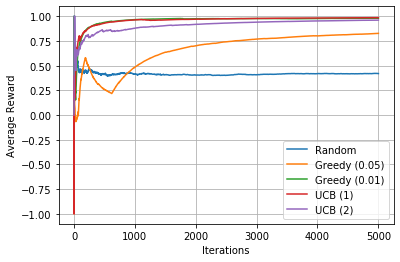

In [3]:
results = {'Random': [], 
           'Greedy (0.05)': [], 
           'Greedy (0.01)': [], 
           'UCB (1)': [],
           'UCB (2)': []}

for i, (func, e) in enumerate([('random', 0), 
                             ('greedy', 0.05), 
                             ('greedy', 0.01), 
                             ('ucb', 1),
                             ('ucb', 2)]):

    m = MCTS(Tic(np.array([3, 2, 5, 7])))
    m.search(5000, func, e)
    
    results[list(results.keys())[i]] = [-i for i in m.root.mean_rewards]
    
    
plt.plot(results['Random'], label='Random')
plt.plot(results['Greedy (0.05)'], label='Greedy (0.05)')
plt.plot(results['Greedy (0.01)'], label='Greedy (0.01)')
plt.plot(results['UCB (1)'], label='UCB (1)')
plt.plot(results['UCB (2)'], label='UCB (2)')


plt.xlabel('Iterations')
plt.ylabel('Average Reward')
plt.grid()
plt.legend()

plt.show()

[[b'_' b'_' b'_']
 [b'_' b'_' b'_']
 [b'X' b'_' b'_']]

[[b'_' b'_' b'_']
 [b'_' b'_' b'O']
 [b'X' b'_' b'_']]

[[b'_' b'_' b'_']
 [b'_' b'X' b'O']
 [b'X' b'_' b'_']]

[[b'_' b'O' b'_']
 [b'_' b'X' b'O']
 [b'X' b'_' b'_']]

[[b'_' b'O' b'_']
 [b'_' b'X' b'O']
 [b'X' b'X' b'_']]

[[b'O' b'O' b'_']
 [b'_' b'X' b'O']
 [b'X' b'X' b'_']]

[[b'O' b'O' b'_']
 [b'X' b'X' b'O']
 [b'X' b'X' b'_']]

[[b'O' b'O' b'_']
 [b'X' b'X' b'O']
 [b'X' b'X' b'O']]

[[b'O' b'O' b'X']
 [b'X' b'X' b'O']
 [b'X' b'X' b'O']]
crosses wins

[[b'_' b'_' b'_']
 [b'_' b'_' b'_']
 [b'_' b'_' b'X']]

[[b'_' b'_' b'_']
 [b'_' b'O' b'_']
 [b'_' b'_' b'X']]

[[b'_' b'_' b'_']
 [b'_' b'O' b'_']
 [b'_' b'X' b'X']]

[[b'_' b'_' b'_']
 [b'_' b'O' b'_']
 [b'O' b'X' b'X']]

[[b'_' b'_' b'X']
 [b'_' b'O' b'_']
 [b'O' b'X' b'X']]

[[b'_' b'_' b'X']
 [b'_' b'O' b'O']
 [b'O' b'X' b'X']]

[[b'_' b'_' b'X']
 [b'X' b'O' b'O']
 [b'O' b'X' b'X']]

[[b'O' b'_' b'X']
 [b'X' b'O' b'O']
 [b'O' b'X' b'X']]

[[b'O' b'X' b'X']
 [b'X' b'O' b'O']

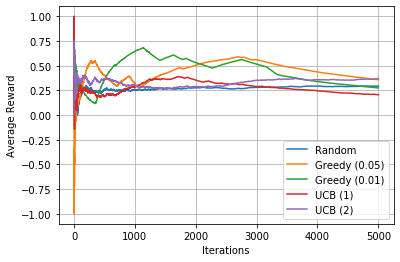

In [4]:
results = {'Random': [], 
           'Greedy (0.05)': [], 
           'Greedy (0.01)': [], 
           'UCB (1)': [],
           'UCB (2)': []}

for i, (func, e) in enumerate([('random', 0), 
                             ('greedy', 0.05), 
                             ('greedy', 0.01), 
                             ('ucb', 1),
                             ('ucb', 2)]):

    m = MCTS(Tic())
    m.search(5000, func, e)
    
    results[list(results.keys())[i]] = [-i for i in m.root.mean_rewards]
    
    
plt.plot(results['Random'], label='Random')
plt.plot(results['Greedy (0.05)'], label='Greedy (0.05)')
plt.plot(results['Greedy (0.01)'], label='Greedy (0.01)')
plt.plot(results['UCB (1)'], label='UCB (1)')
plt.plot(results['UCB (2)'], label='UCB (2)')


plt.xlabel('Iterations')
plt.ylabel('Average Reward')
plt.grid()
plt.legend()

plt.show()

[[b'_' b'O' b'X']
 [b'_' b'X' b'_']
 [b'_' b'_' b'_']]

[[b'_' b'O' b'X']
 [b'_' b'X' b'_']
 [b'_' b'O' b'_']]

[[b'_' b'O' b'X']
 [b'_' b'X' b'X']
 [b'_' b'O' b'_']]

[[b'_' b'O' b'X']
 [b'_' b'X' b'X']
 [b'_' b'O' b'O']]

[[b'X' b'O' b'X']
 [b'_' b'X' b'X']
 [b'_' b'O' b'O']]

[[b'X' b'O' b'X']
 [b'O' b'X' b'X']
 [b'_' b'O' b'O']]

[[b'X' b'O' b'X']
 [b'O' b'X' b'X']
 [b'X' b'O' b'O']]
crosses wins

[[b'X' b'O' b'_']
 [b'_' b'X' b'_']
 [b'_' b'_' b'_']]

[[b'X' b'O' b'_']
 [b'_' b'X' b'O']
 [b'_' b'_' b'_']]

[[b'X' b'O' b'X']
 [b'_' b'X' b'O']
 [b'_' b'_' b'_']]

[[b'X' b'O' b'X']
 [b'O' b'X' b'O']
 [b'_' b'_' b'_']]

[[b'X' b'O' b'X']
 [b'O' b'X' b'O']
 [b'X' b'_' b'_']]
crosses wins

[[b'_' b'O' b'_']
 [b'_' b'X' b'_']
 [b'_' b'_' b'X']]

[[b'O' b'O' b'_']
 [b'_' b'X' b'_']
 [b'_' b'_' b'X']]

[[b'O' b'O' b'X']
 [b'_' b'X' b'_']
 [b'_' b'_' b'X']]

[[b'O' b'O' b'X']
 [b'_' b'X' b'_']
 [b'O' b'_' b'X']]

[[b'O' b'O' b'X']
 [b'_' b'X' b'X']
 [b'O' b'_' b'X']]
crosses wins

[[b'_' b'

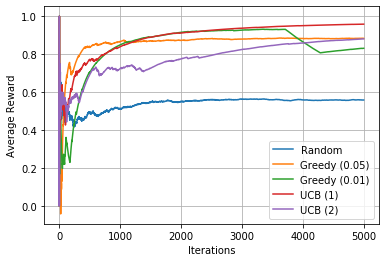

In [5]:
results = {'Random': [], 
           'Greedy (0.05)': [], 
           'Greedy (0.01)': [], 
           'UCB (1)': [],
           'UCB (2)': []}

for i, (func, e) in enumerate([('random', 0), 
                             ('greedy', 0.05), 
                             ('greedy', 0.01), 
                             ('ucb', 1),
                             ('ucb', 2)]):

    m = MCTS(Tic(np.array([5, 2])))
    m.search(5000, func, e)
    
    results[list(results.keys())[i]] = [-i for i in m.root.mean_rewards]
    
    
plt.plot(results['Random'], label='Random')
plt.plot(results['Greedy (0.05)'], label='Greedy (0.05)')
plt.plot(results['Greedy (0.01)'], label='Greedy (0.01)')
plt.plot(results['UCB (1)'], label='UCB (1)')
plt.plot(results['UCB (2)'], label='UCB (2)')


plt.xlabel('Iterations')
plt.ylabel('Average Reward')
plt.grid()
plt.legend()

plt.show()